# Instrumental Noise in _Kepler_ and _K2_ #4: Electronic Noise

## Learning Goals

By the end of this tutorial, you will be able to:

- Explain electronic crosstalk and how it manifests in _Kepler_ data.
- Identify rolling bands in _Kepler_ data and compare their effect to other sources of noise.
- Understand the short- and long-term consequences of cosmic rays on the _Kepler_ detector.


## Introduction

This tutorial is the fourth part of a series on identifying instrumental and systematic sources of noise in _Kepler_ and _K2_ data. The first three tutorials in this series are suggested (but not necessary) reading for working through this one.  Assumed knowledge for this tutorial is a working familiarity with _Kepler_ light curve files, target pixel files, and their associated metadata.

## Imports

We'll use **[Lightkurve](https://docs.lightkurve.org/)** for downloading and handling _Kepler_ data throughout this tutorial. We'll also use **[NumPy](https://numpy.org/)** to handle arrays for aperture masks, and **[Matplotlib](https://matplotlib.org/)** to help with some plotting.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

## 1. Background

The *Kepler* space telescope operated as a *photometer*: using charge-coupled devices (CCDs), *Kepler* collected photons and processed these as flux measurements. The detector array consisted of 25 modules, and 94.6 million pixels. With an instrument of this size, electronic noise issues are inevitable. In this tutorial, we'll look at three major sources of electronic noise that occurred throughout both the *Kepler* and *K2* missions.

## 2. Crosstalk

Crosstalk refers to the phenomenon where an electronic signal from one channel of a device is transferred to another channel and causes noise. In _Kepler_ and _K2_ data, this often manifests as signal from one (usually bright) target appearing elsewhere on the detector. This is known as "video crosstalk," and only has a significant effect when it occurs on the same module, due to the shielding between modules ([_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf) Section 6.3). _Kepler_ crosstalk can also occur between the CCD modules and the Fine Guidance Sensors (FGS), and between either of these and the onboard clock. However, these kinds of crosstalk are well understood and corrected by the pipeline before data delivery. If you are interested in reading more about these types of crosstalk, they're covered in Sections 6.2 and 6.4 of the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf).

To understand what video crosstalk looks like, let's take an example from the _K2_ mission, as documented [here](https://github.com/KeplerGO/lightkurve/issues/160). UGC 7394 (EPIC 200084891) is a galaxy that was observed during _K2_ Campaign 10. Campaign 10 was delivered in two parts, as observation began with a pointing error of 3.5 pixels ([_K2_ Data Release Notes 15](https://archive.stsci.edu/missions/k2/doc/drn/KSCI-19131-001_K2-DRN15_C10.pdf), Section 2.1), so when we download our data using Lightkurve we have to specify which file we want. Let's begin with Campaign 10a:

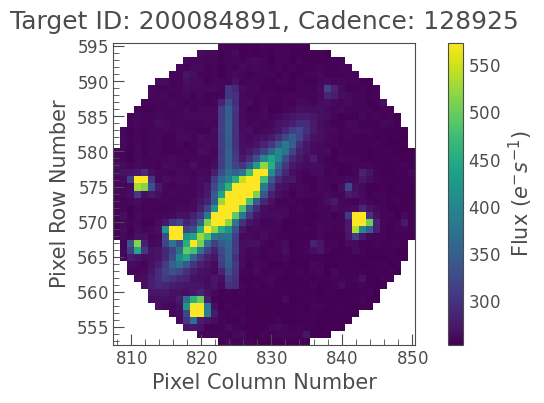

In [2]:
tpf_ct = lk.search_targetpixelfile('EPIC 200084891', author="K2", campaign=10)[0].download()
tpf_ct.plot();

UGC 7394 is very clear in this image, but there's also a column of what looks like saturation bleed down the middle. In fact, this is video crosstalk from a nearby bright star. The separation between these two sources becomes even more clear when we check Campaign 10b, which used a slightly different pointing:

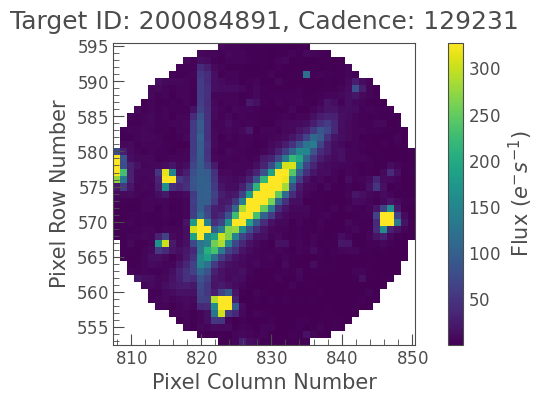

In [3]:
tpf_ct = lk.search_targetpixelfile('EPIC 200084891', author="K2", campaign=10)[1].download()
tpf_ct.plot();

You can also check for yourself that the crosstalk source is unrelated to the galaxy by using Lightkurve's [interact()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.interact.html?highlight=interact#lightkurve.KeplerTargetPixelFile.interact) function offline and noting that the spreads of the two sources on the detector differ independently.

## 3. Rolling Bands

The _Kepler_ detector electronics have a high-frequency noise feature due to circuit self-resonance in the GHz range, which is aliased to lower frequencies by the pixel sampling rate for detector readout. These aliases lead to changing temperatures and pixel sensitivities on the focal plane, which appear as horizontal stripes in motion across on the detector. For a more technical exploration of this phenomenon, see Section 6.7 of the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf).

Let's have a look at an example of rolling bands in _K2_ data (as documented [here](https://github.com/KeplerGO/lightkurve/issues/160)). This star, EPIC 211741417, has a rolling band passing across its aperture, beginning around 3306 BKJD (Barycentric _Kepler_ Julian Date) days. First we'll download some data, and see if the rolling bands are visible in a cadence taken from before the rolling band passes (left), and after it passes (right). We'll also make sure the images have the same color scale, so we can make a fair comparison.

In [4]:
tpf_rbs = lk.search_targetpixelfile('EPIC 211741417', author="K2", campaign=16).download()

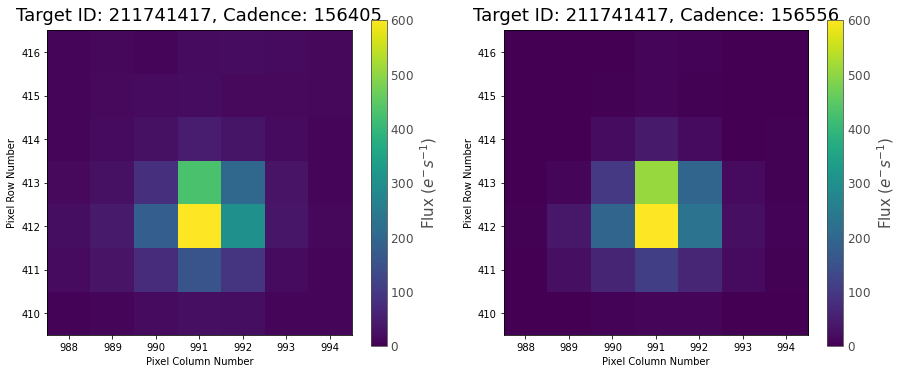

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
tpf_rbs.plot(ax=ax[0], cadenceno=156405, vmin=0, vmax=600)
tpf_rbs.plot(ax=ax[1], cadenceno=156556, vmin=0, vmax=600);

There's nothing obvious here; the background is a little darker during the rolling band event, but not noticeably so on this scale. To get a better look at this, you can use Lightkurve's [interact()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.interact.html?highlight=interact#lightkurve.KeplerTargetPixelFile.interact) function in an offline notebook. However, it's also possible to observe the rolling band by looking at some light curves.

We'll extract two single-pixel light curves for two pixels in this target pixel file (TPF): the brightest pixel where the target lies, and the bottom left pixel as representative of the background flux. First, we'll make an aperture mask for each; you can read more about this process in the custom aperture photometry tutorial.

In [6]:
target_mask = np.zeros((tpf_rbs[0].shape[1:]), dtype='bool')
target_mask[2,3] = True
background_mask = np.zeros((tpf_rbs[0].shape[1:]), dtype='bool')
background_mask[0,0] = True

Now let's look at the bright pixel and highlight the region where we expect to see the effects of the rolling band:

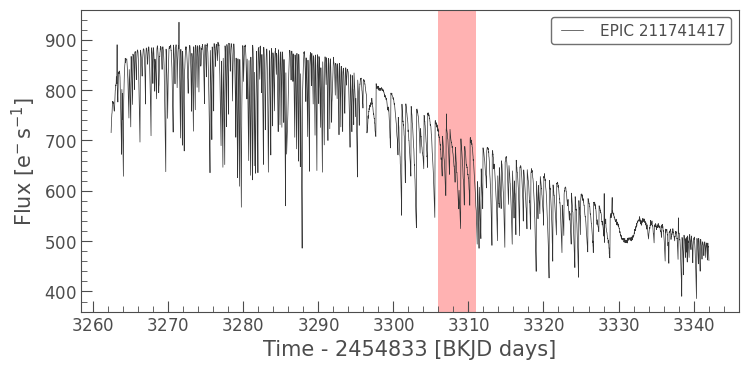

In [7]:
ax = tpf_rbs.to_lightcurve(aperture_mask=target_mask).plot()
ax.set_ylim(360, 960)
ax.fill_betweenx(ax.get_ylim(), 3306, 3311, facecolor='r', alpha=0.3)

This light curve shows the _K2_ six-hour pointing drift, and an overall trend due to temperature changes on the detector. There is no noticeable change during the rolling band crossing. This tells us that this star is bright enough that the effect of the rolling band is negligible in comparison.

Now let's look at the background pixel light curve:

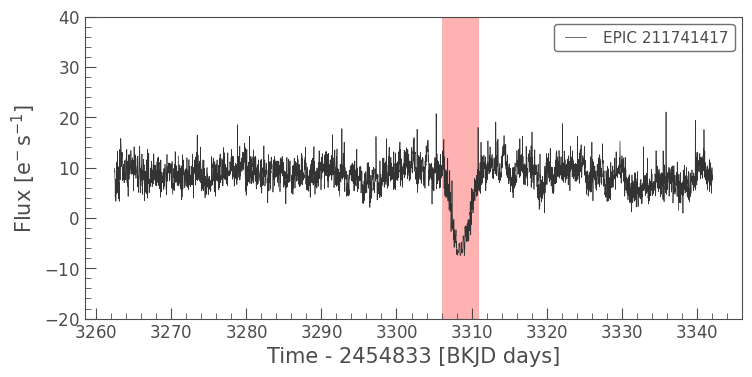

In [8]:
ax = tpf_rbs.to_lightcurve(aperture_mask=background_mask).remove_outliers().plot()
ax.set_ylim(-20, 40)
ax.fill_betweenx(ax.get_ylim(), 3306, 3311, facecolor='r', alpha=0.3);

Sure enough, we can see a dip in background flux as the rolling band passes over the TPF. Note the scale of this dip; this low amplitude confirms what we saw above, that rolling bands are negligible in amplitude compared to target flux, six-hour drift, and temperature-induced flux variations. Nevertheless, it's important to be aware of rolling bands in your data when searching for noise sources and working on background modeling.

Rolling bands are identified by quality flags 18 and 19 in light curve and TPF metadata ([MAST Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_documents/MAST_Kepler_Archive_Manual_2020.pdf), Table 2-3), but the automated flags are incomplete and do not detect all rolling bands. For further reading, there is a [Lightkurve tutorial](https://docs.lightkurve.org/tutorials/04-identify-rolling-band.html) on checking for rolling bands in _Kepler_ data.

## 4. Cosmic Rays and Sudden Pixel Sensitivity Dropout

In the first tutorial in this series, we covered cosmic rays as single-cadence quality events. We saw that when a cosmic ray hits a pixel on the detector, it can momentarily increase that pixel's flux reading by injecting noise in between readouts. However, there are multiple other consequences of cosmic rays on the detector that occurred over the course of the _Kepler_ and _K2_ missions.

Sudden Pixel Sensitivity Dropout (SPSD) occurs when a cosmic ray _reduces_ the sensitivity of a group of pixels where it lands. SPSD events are categorized as medium-term and long-term (or permanent) damage. In medium-term events, the effected pixels will gradually return to their pre-SPSD sensitivity. Long-term damage would require [annealing](https://en.wikipedia.org/wiki/Annealing_(metallurgy)) to fix, which could not be done on the _Kepler_ telescope, and as such is materially equivalent to permanent damage. Pixels affected by long-term or permanent damage retained their decreased sensitivity throughout the mission. For further reading, see the [_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.9.

To observe an SPSD event, let's download some data first:

In [9]:
cr = lk.search_lightcurve('KIC 7461601', author="Kepler", quarter=6).download(quality_bitmask=0)

Recalling from the first tutorial in this series that cosmic ray events are flagged in the `QUALITY` column of light curve and TPF metadata, let's look at the particular quality flag we're interested in:

In [10]:
lk.KeplerQualityFlags.decode(1152)

['Cosmic ray in optimal aperture', 'Sudden sensitivity dropout']

Now let's plot the simple aperture photometry (SAP) flux of the star we downloaded, with a dashed line where we expect to see a SPSD event:

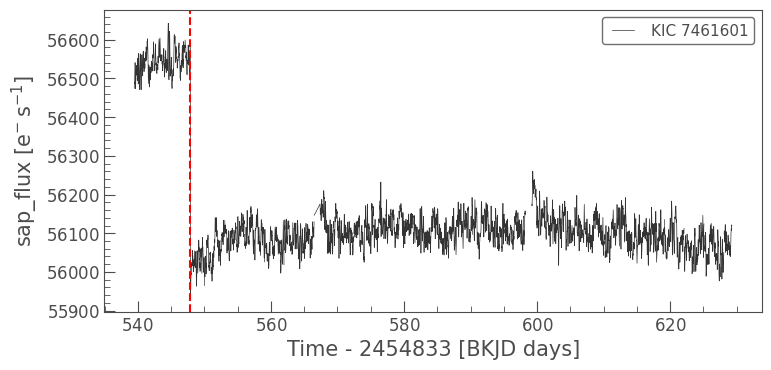

In [11]:
ax = cr.plot(column='sap_flux')
ymin, ymax = ax.get_ylim()
ax.axvline(cr.time.value[cr.quality.value==1152][0], c='r', ls='--');

In the above image, we can see that the flux level drops abruptly around 547 BKJD days. This is due to a cosmic ray hitting the optimal aperture containing pixels used for photometry, and causing a sudden decrease in pixel sensitivity.

This effect is corrected by the presearch data conditioning (PDC) pipeline:

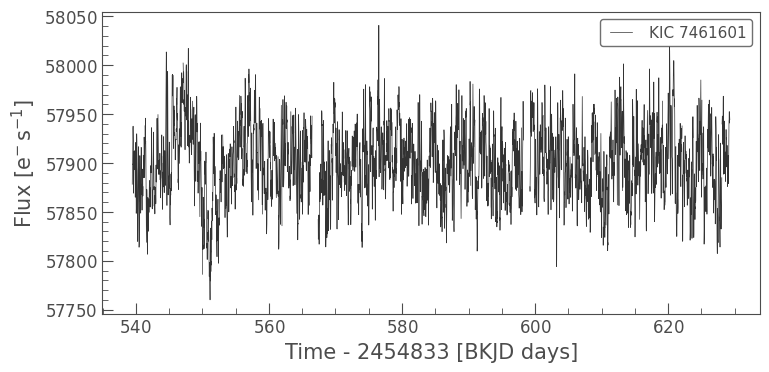

In [12]:
cr.plot();

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)

**Updated on:** 2020-09-29

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [13]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>